In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataset import random_split
from torchvision import datasets
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = self.softmax(x)
        return output

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net()
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=.01,
                      momentum=0.5)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on CPU...


In [ ]:
max_epochs = 30
batch_size_train = 64
batch_size_test = 1


random_seed = 671
torch.manual_seed(random_seed)

In [ ]:
train_set = datasets.MNIST('mnist_data', train=True, download=True,
         transform=torchvision.transforms.ToTensor())

test_set =  datasets.MNIST('mnist_data', train=False, download=True,
         transform=torchvision.transforms.ToTensor())

all_MNIST = train_set + test_set

train_amt = 35000
test_amt = 35000
train_set, test_set = random_split(all_MNIST,[train_amt, test_amt])


train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size_train, shuffle=True)
train_loader_test = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size_test, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [ ]:

def train(net):
    losses = []

    net.train()

    for epoch in range(max_epochs):
        print(epoch)
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad()
            out = net.forward(data)

            loss = nn.NLLLoss()
            myloss = loss(out,target)

            myloss.backward()

            optimizer.step()

            epoch_loss = epoch_loss + myloss.item()

        losses = losses + [epoch_loss/len(train_loader)]


    return losses


In [ ]:
losses = train(net)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Text(0.5, 1.0, 'Losses over Epochs')

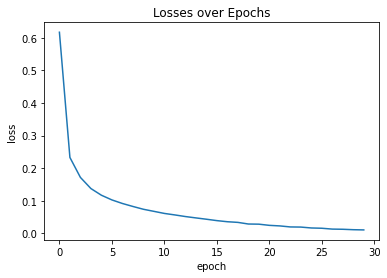

In [ ]:
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Losses over Epochs")

I think it begins to really converge with less than 5% loss around after the 15th epoch

In [ ]:

def get_confusion_matrix(net, data_loader):
    predictions = []
    targets = []

    net.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            out = net(data)
            _, predicted = out.max(1)

            predictions = predictions +  predicted.numpy().tolist()
            targets = targets + target.numpy().tolist()

            if batch_idx % 5000 == 0:
                print('Finished Image #', batch_idx)


    return confusion_matrix(targets, predictions), np.array(predictions), np.array(targets)

In [ ]:
tr_conf, tr_pred, tr_targ = get_confusion_matrix(net, train_loader)
test_conf, test_pred, test_targ = get_confusion_matrix(net,test_loader)

print("Training Confusion Matrix")
print(tr_conf)
print("Testing Confusion Matrix")
print(test_conf)

Finished Image # 0
Finished Image # 0
Finished Image # 5000
Finished Image # 10000
Finished Image # 15000
Finished Image # 20000
Finished Image # 25000
Finished Image # 30000
Training Confusion Matrix
[[3414    0    0    0    0    0    0    0    0    0]
 [   0 3907    0    0    0    0    0    2    0    0]
 [   1    8 3465    5    2    0    0    8    1    0]
 [   0    0    0 3554    0    0    0    2    5    0]
 [   0    1    0    0 3394    0    0    2    0    0]
 [   1    2    0   52    0 3085    3    0   17    3]
 [   2    4    0    0    0    0 3484    0    0    0]
 [   0    1    0    0    0    0    0 3650    1    2]
 [   2    8    0    3    0    0    1    1 3423    0]
 [   4    4    0    5    6    0    0    7   11 3447]]
Testing Confusion Matrix
[[3451    5    4    2    0    3    3    2   14    5]
 [   0 3949    7    3    0    0    2    3    3    1]
 [   9   12 3408   13    3    1    2   30   21    1]
 [   2    8   15 3497    0   11    1   14   24    8]
 [   4   11    3    1 3360    0

In [ ]:
tr_acc = np.trace(tr_conf)/35000
test_acc = np.trace(test_conf)/35000
print("Training Accuracy: "+str(tr_acc))
print("\nTesting Accuracy: "+str(test_acc))

Training Accuracy: 0.9949428571428571

Testing Accuracy: 0.9777714285714286


My intuition is that since the testing accuracy is not substantially different from the training accuracy, the model isn't really overfitting yet.

By my observation, it looks like the model thinks a lot of things are 8s that aren't actually 8s, and also similarly we experience the same where the model seems to mispredict things as 9s a lot of times they're not actually 9s (especially 7s). This makes sense as these numbers look to be similar and less uniquely shaped than other numbers. On the other hand, the model frequently misclassifies its 7s and 9s, which fits into the story we have of what it thinks numbers are from above.

In [ ]:

trainset_list = list(zip(*train_set))
X_train = np.array([trainset_list[0][index].numpy().flatten() for index in range(train_amt)])

Y_train = np.array([trainset_list[1][index] for index in range(train_amt)])

testset_list = list(zip(*test_set))
X_test = np.array([testset_list[0][index].numpy().flatten() for index in range(test_amt)])

Y_test = np.array([testset_list[1][index] for index in range(test_amt)])

In [ ]:
model = LogisticRegression(solver = "saga")
model.fit(X_train, Y_train)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(solver='saga')

In [ ]:
tr_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("Training Confusion Matrix")
tr_conf = confusion_matrix(Y_train, tr_pred)
print(tr_conf)
print("Training Accuracy: "+ str(np.trace(tr_conf)/35000))
print("\nTesting Confusion Matrix")
test_conf = confusion_matrix(Y_test,test_pred)
print(test_conf)
print("Testing Accuracy "+str(np.trace(test_conf)/35000))

Training Confusion Matrix
[[3348    0    8    3    7   18   15    1   12    2]
 [   1 3823   16   13    3   12    1    6   28    6]
 [  10   25 3221   41   34   16   30   28   74   11]
 [   5   12   72 3268    3   99    4   23   47   28]
 [   6    8   12    5 3233    4   22    4   18   85]
 [  18   12   20   86   30 2862   42    9   70   14]
 [  11    8   15    2   20   39 3384    2    9    0]
 [   2   10   32   13   18    5    2 3473    7   92]
 [   9   47   29   66    7   75   24    9 3138   34]
 [  16   18   11   34   64   12    0   81   20 3228]]
Training Accuracy: 0.9422285714285714

Testing Confusion Matrix
[[3354    1   12   11    7   26   33   10   27    8]
 [   0 3867   17    7    1   18    5    6   40    7]
 [  23   36 3142   47   47   15   53   47   77   13]
 [  17   24   84 3181    3  116   14   28   74   39]
 [   3   22   23    7 3189    4   29   13   29  108]
 [  33   20   29   94   29 2763   48   12   85   37]
 [  23    7   40    0   25   55 3213    7   15    1]
 [   8  

The logistic regression does not seem to be significantly more overfitting than the neural network, as the training and test accuracy are both fairly similar, albeit some degree of overfitting might be starting to happen. It does seem to be getting confused on the same images. It misclassifies many things as 9s, 8s, and 5s, and tends to misclassify proportionally a lot more 4s than the neural network, 7s, 8s, and 9s.

In [ ]:
mod = KMeans(n_clusters=10,init="random", n_init=5,random_state=24)
mod.fit(X_test)

predictions = mod.predict(X_test)

In [ ]:
cluster_count = np.zeros((10,10))
label = np.zeros(10)
for i in range(len(predictions)):
  cluster_count[predictions[i]][Y_test[i]]+=1

In [ ]:
for i in range(10):
  label[i] = np.argmax(cluster_count[i])

In [ ]:
pred_label = [label[i] for i in predictions]

In [ ]:
km_conf = confusion_matrix(Y_test,pred_label)
print("K Means Confusion Matrix")
print(km_conf)
print("K Means Accuracy: " + str(np.trace(km_conf)/35000))

K Means Confusion Matrix
[[3068   14   16  113   34    0  118   14  103    9]
 [   0 3899   19    8    4    0    8    1   18   11]
 [  75  411 2464  196  108    0   96   38   82   30]
 [  62  242  148 2365   42    0   32   29  585   75]
 [   3  133   13    0 1293    0   76  973    8  928]
 [ 144  488   10 1039  117    0   70  247  884  151]
 [ 125  247   50   17  246    0 2651    0   49    1]
 [  12  233   25    1  339    0    4 1583    4 1438]
 [  44  339   35  609   69    0   37  147 2004  103]
 [  24   95    4   46  838    0    5  959   27 1476]]
K Means Accuracy: 0.5943714285714286


K Means does significantly worse than the other methods (logistic regression and neural network). It boasts around 60% accuracy on its respective training data, which is a drop off of more than 30 percentage points for the other methods. It does a lot of misclassification, and a large part of that was that it seems (based on the confusion matrix) to have created 2 clusters that in reality actually end up labeling the same number, so one number (in this case 5) is never classified.